# A TRUE NEWS RECOMMENDER BASED ON AN TF-IDF VARIATION AND TOPIC MODELLING

The aim is to create a model that takes one news article as a query and based on that recommends 5 further relevant articles to the reader. Relevancy is here defined as covering the same or a similar topic. Doing so the model evaluates, whether these articles are true or fake and only recommends true news.

- Importing the necessary libraries and doing initial preparations

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import sys
import csv
import seaborn as sb
from collections import OrderedDict
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, precision_score, recall_score
from transformers import BertTokenizer
import torch
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
import torch
import transformers
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from tqdm import tqdm


/Users/luka/opt/miniconda3/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
nltk.download('stopwords')
nltk.download('punkt')

from nltk.stem.snowball import SnowballStemmer

[nltk_data] Downloading package stopwords to /Users/luka/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/luka/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Reading in the data

In [3]:
csv.field_size_limit(sys.maxsize)

news = pd.read_csv('WELFake_Dataset.csv', engine='python', encoding='utf-8', on_bad_lines='skip').fillna('')

## EXPLORATORY DATA ANALYSIS AND PREPARATIONS FOR THE NEURAL NETWORK MODEL

Taking a first look at the data frame

In [4]:
news.head(10)

,Unnamed: 0,title,text,label
0,0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
1,1,,Did they post their votes for Hillary already?,1
2,2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1
3,3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
4,4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1
5,5,About Time! Christian Group Sues Amazon and SP...,All we can say on this one is it s about time ...,1
6,6,DR BEN CARSON TARGETED BY THE IRS: “I never ha...,DR. BEN CARSON TELLS THE STORY OF WHAT HAPPENE...,1
7,7,HOUSE INTEL CHAIR On Trump-Russia Fake Story: ...,,1
8,8,Sports Bar Owner Bans NFL Games…Will Show Only...,"The owner of the Ringling Bar, located south o...",1
9,9,Latest Pipeline Leak Underscores Dangers Of Da...,"FILE – In this Sept. 15, 2005 file photo, the ...",1


In [5]:
news.nunique()

Unnamed: 0    72134
title         62348
text          62719
label             2
dtype: int64

We can see that some titles as well as some texts are missing

Checking the number of fake news and true news aricles

In [6]:
n_fake_news = int(news["label"].value_counts()[0])
n_true_news = int(news["label"].value_counts()[1])

n_fake_news, n_true_news

(35028, 37106)

<BarContainer object of 2 artists>

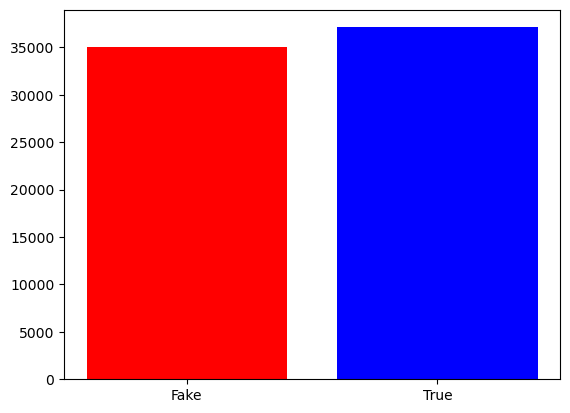

In [7]:
x = np.array(["Fake", "True"])
y = np.array([news['label'].value_counts()[0], news['label'].value_counts()[1]])

plt.bar(x,y, color = ["red","blue"])

Basically we see a relative balance between fake and true news, with a little bit more of tn. 

With such a large dataset of 72000 a NN applied to all the texts would use too many ressources. Therefore we want to use the titles (as they are shorter) as input and add to them some words from the text that are more frequent in a specific kind of news type. We therefore need to find a way to identify those words.

### CLEANING UP THE TEXT

In [8]:
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")

In [9]:
def remove_punctuation(some_string):
    unpuncted_string = some_string.translate(str.maketrans("","",string.punctuation))
    unpuncted_string = unpuncted_string.translate(str.maketrans("","","—"))
    unpuncted_string = unpuncted_string.translate(str.maketrans("","",'”'))
    unpuncted_string = unpuncted_string.translate(str.maketrans("","",'“'))
    unpuncted_string = unpuncted_string.translate(str.maketrans("","","–"))
    unpuncted_string = unpuncted_string.translate(str.maketrans("","","•"))   
    unpuncted_string = unpuncted_string.translate(str.maketrans("","","’"))   
    unpuncted_string = unpuncted_string.translate(str.maketrans("","","›"))   
    unpuncted_string = unpuncted_string.translate(str.maketrans("","","■"))   
    unpuncted_string = unpuncted_string.translate(str.maketrans("","","в"))   
    unpuncted_string = unpuncted_string.translate(str.maketrans("","","и"))   
    return(unpuncted_string)

## We found some unusual symbols during our testruns, which were not removed as punctuation. We therefore removed these via direct code.

In [10]:
def remove_stopwords(some_list):
    new_list = [word for word in some_list if word not in stop_words]
    return new_list

In [11]:
def apply_stemming(some_list):
    new_list = []
    for word in some_list:
        word = stemmer.stem(word)
        new_list.append(word)
    return(new_list)

In [12]:
news["text_clean"] = news["text"].apply(remove_punctuation)
news["text_clean"] = news["text_clean"].apply(nltk.word_tokenize)
news["text_clean"] = news["text_clean"].apply(apply_stemming)
news["text_clean"] = news["text_clean"].apply(remove_stopwords)

## Further Exploring

Checking the df with its new column. The text (if there was some) has been converted to a list of stemmed, stopword-free terms. This allows for better analysis. 

In [13]:
news.head(10)

,Unnamed: 0,title,text,label,text_clean
0,0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1,"[comment, expect, barack, obama, member, fyf91..."
1,1,,Did they post their votes for Hillary already?,1,"[post, vote, hillari, alreadi]"
2,2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1,"[demonstr, gather, last, night, exercis, const..."
3,3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0,"[dozen, polit, activ, pastor, came, privat, di..."
4,4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1,"[rs28, sarmat, missil, dub, satan, 2, replac, ..."
5,5,About Time! Christian Group Sues Amazon and SP...,All we can say on this one is it s about time ...,1,"[say, one, time, someon, su, southern, poverti..."
6,6,DR BEN CARSON TARGETED BY THE IRS: “I never ha...,DR. BEN CARSON TELLS THE STORY OF WHAT HAPPENE...,1,"[dr, ben, carson, tell, stori, happen, spoke, ..."
7,7,HOUSE INTEL CHAIR On Trump-Russia Fake Story: ...,,1,[]
8,8,Sports Bar Owner Bans NFL Games…Will Show Only...,"The owner of the Ringling Bar, located south o...",1,"[owner, ringl, bar, locat, south, white, sulph..."
9,9,Latest Pipeline Leak Underscores Dangers Of Da...,"FILE – In this Sept. 15, 2005 file photo, the ...",1,"[file, sept, 15, 2005, file, photo, marker, we..."


In a next step we want to know, how often the terms contained in the cleaned text occur throughout all the documents. Further we are interested, how often they appear in each respective news type (fake or true).

In [14]:
def calculate_word_occurences(text, labels):
  occurence = {}
  occurence_in_fake_articles = {}
  occurence_in_real_articles = {}
  for sentence, label in zip(text, labels):
    for word in sentence:
      if label == 1:
        if word in occurence_in_real_articles:
          occurence_in_real_articles[word] += 1
        else:
          occurence_in_real_articles[word] = 1
      else:
        if word in occurence_in_fake_articles:
          occurence_in_fake_articles[word] += 1
        else:
          occurence_in_fake_articles[word] = 1

      if word in occurence:
        occurence[word] += 1
      else:
        occurence[word] = 1

  occurence = dict(sorted(occurence.items(), key=lambda item: item[1], reverse=True))
  occurence_in_fake_articles = dict(sorted(occurence_in_fake_articles.items(), key=lambda item: item[1], reverse=True))
  occurence_in_real_articles = dict(sorted(occurence_in_real_articles.items(), key=lambda item: item[1], reverse=True))
  
  return occurence, occurence_in_fake_articles, occurence_in_real_articles

We apply this function and further create a dictionary, measuring how much certain words polarize in terms of frequency. With that we mean whether a certain term apears more often in one type of news than in the other. Looking at pure frequencies, we just subtract the number of times it appears in true news from the number for fake news. Negative values then mean that the term is more frequent in true news and positive values show that it appears more often in fake news. 

In [15]:
word_occurence, occurrence_fake, occurrence_real = calculate_word_occurences(news["text_clean"], news["label"])
word_occurence_top = {k: word_occurence[k] for k in list(word_occurence)[:10]}

word_keys = list(word_occurence.keys())
polarizing_word_dict = {}
for word in word_keys:
    if word not in occurrence_fake:
        a = 0
        b = occurrence_real[word]
    elif word not in occurrence_real:
        a = occurrence_fake[word]
        b = 0
    else:
        a = occurrence_fake[word]
        b = occurrence_real[word]
    polarizing_word_dict[word] = a-b
        
polarizing_words = sorted(polarizing_word_dict.items(), key=lambda item: item[1], reverse=True)

polarizing_words_absolute = polarizing_words[:10] + polarizing_words[-10:]


Looking at the 10 most frequency-discriminating words for each news type, we find the following.

In [16]:
count = 0
for word in polarizing_words_absolute:
    if word[0] not in occurrence_fake or word[0] not in occurrence_real:
        print(f"{word[0]} appears exclusively in fake or real news")
        count += 1
if count == 0:
    print("None of the 20 most polarizing words regarding the absolute frequency appears exclusively in fake or true news")

print(f"The words with the largest absolute difference in appearance between fake and real news are:{polarizing_words_absolute}")

None of the 20 most polarizing words regarding the absolute frequency appears exclusively in fake or true news
The words with the largest absolute difference in appearance between fake and real news are:[('said', 137663), ('mr', 60178), ('reuter', 27878), ('state', 25090), ('would', 19512), ('republican', 17871), ('year', 16896), ('senat', 15692), ('offici', 14633), ('new', 14388), ('fact', -7975), ('email', -8001), ('media', -8352), ('fbi', -9226), ('america', -9290), ('know', -9854), ('via', -11708), ('imag', -13516), ('clinton', -16598), ('hillari', -23214)]


Visualising the differences in frequency for the 10 most frequent terms throughout the whole dataset.

In [17]:
def generate_plot_data(word_occurences, occurence_in_fake_articles, occurence_in_real_articles):
  words_x = []
  words_fake = []
  words_real = []

  for word in word_occurences:
    if (word not in occurence_in_fake_articles):
      words_fake.append(0)
    else:
      words_fake.append(occurence_in_fake_articles[word])

    if (word not in occurence_in_real_articles):
      words_real.append(0)
    else:
      words_real.append(occurence_in_real_articles[word])

    words_x.append(word)
    
  return words_x, words_fake, words_real

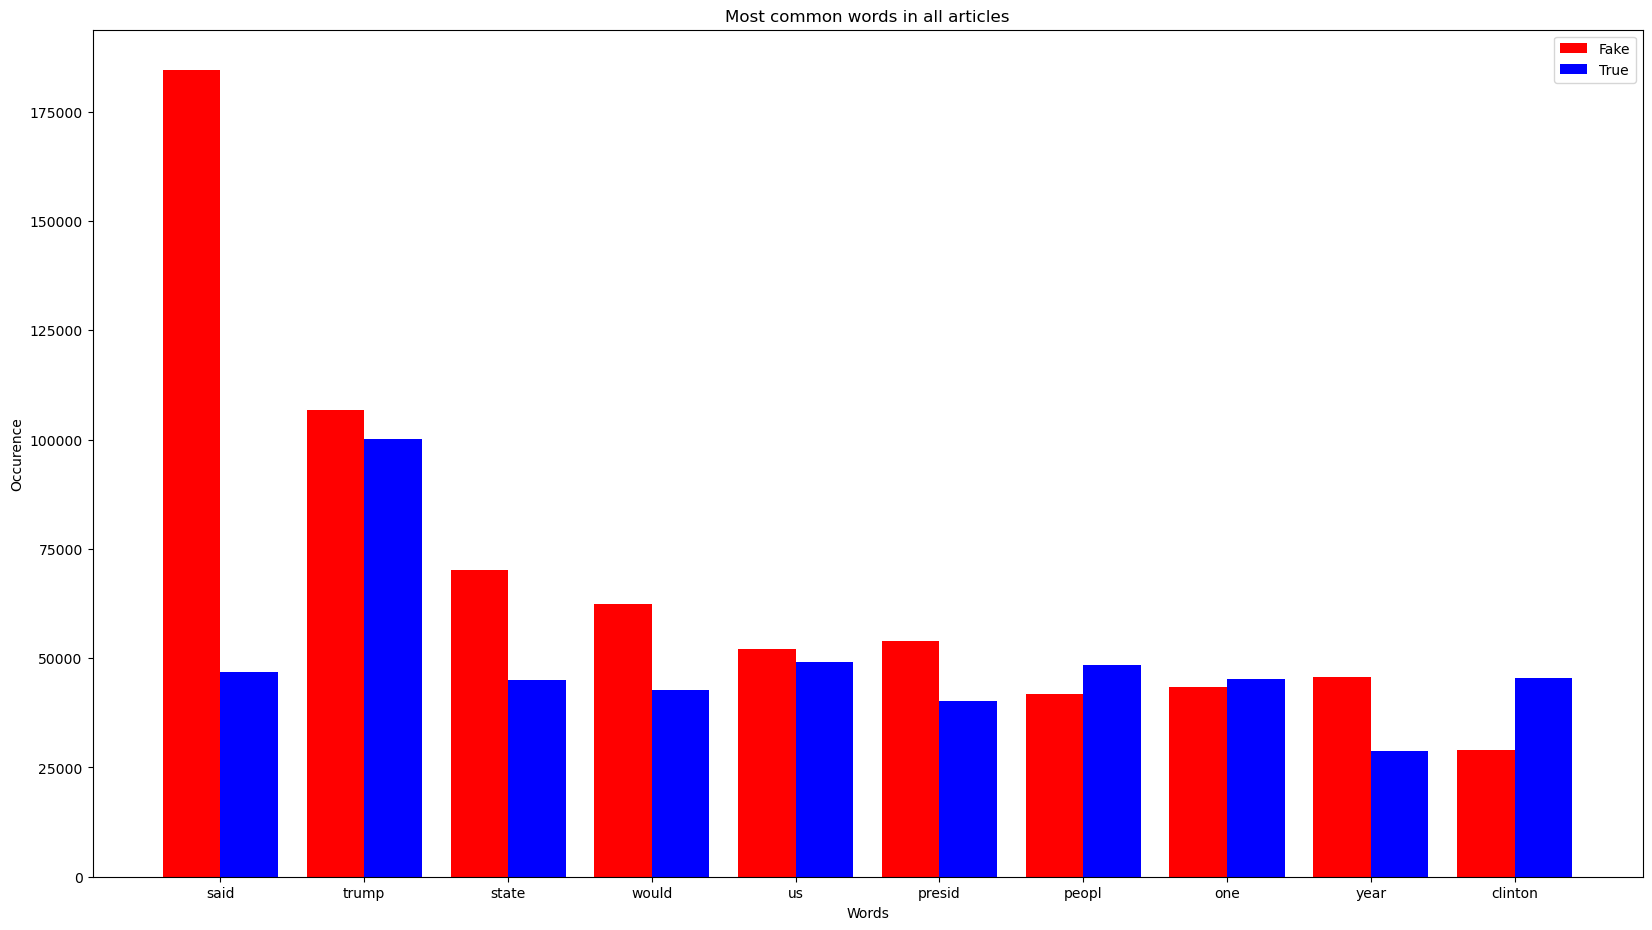

In [18]:
words_x, words_fake, words_true = generate_plot_data(word_occurence_top, occurrence_fake, occurrence_real)
X_axis = np.arange(len(words_x))
plt.figure(figsize=(20, 11)) 
plt.bar(X_axis - 0.2, words_fake, 0.4, label = 'Fake', color="red")
plt.bar(X_axis + 0.2, words_true, 0.4, label = 'True', color="blue")


plt.xticks(X_axis, words_x)
plt.xlabel("Words")
plt.ylabel("Occurence")
plt.title("Most common words in all articles")
plt.legend()
plt.show()

We can see that these terms are frequent in both types of news. Even the (not very meaning loaded) term "said" still appears nearly 50000 times in true news, making it a difficult indicator, even if the difference in frequency between fn and tn is huge. 

Visualising the 10 terms with the largest difference in absolute frequencies between fn and tn.

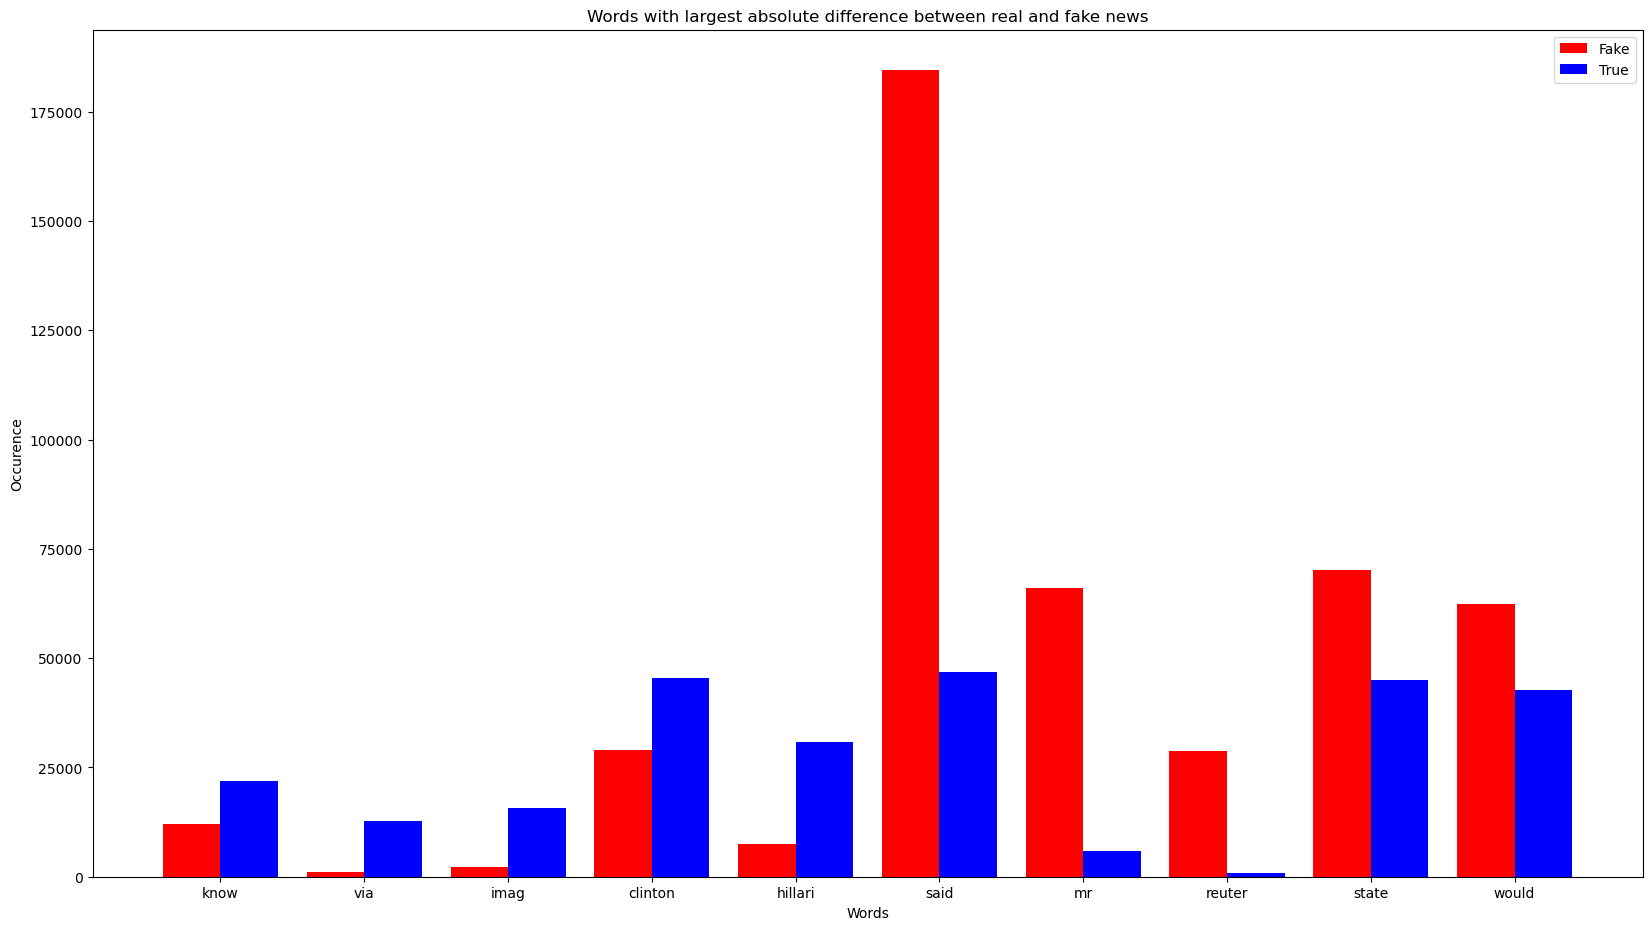

In [19]:
abs_diff_top_ten = [word[0] for word in polarizing_words_absolute[-5:]] + [word[0] for word in polarizing_words_absolute[:5]]
words_x_abs_diff, words_fake_abs_diff, words_true_abs_diff = generate_plot_data(abs_diff_top_ten, occurrence_fake, occurrence_real)
X_axis = np.arange(len(words_x_abs_diff))
plt.figure(figsize=(20, 11)) 
plt.bar(X_axis - 0.2, words_fake_abs_diff, 0.4, label = 'Fake', color="red")
plt.bar(X_axis + 0.2, words_true_abs_diff, 0.4, label = 'True', color="blue")


plt.xticks(X_axis, words_x_abs_diff)
plt.xlabel("Words")
plt.ylabel("Occurence")
plt.title("Words with largest absolute difference between real and fake news")
plt.legend()
plt.show()

Again the word "said" tops all others. But something else caught our eye here. The term "reuter" is very present in fake news but nearly non-existent in true news. It reffers to the news agency Reuters - actually quite a credible source. A closer look at the data set shows that e.g. Reuters and New York Times articles have been classified as fake news, while articles from Info Wars have been classified as true news. The suspicion arises that the markers "0" and "1" might have been mixed up. This should not be an issue for our task, if they have been mixed up for all documents. But since the data set is composed of several other data sets joined into one, this issue might appear for each sub set differently. It is something to be kept in mind. 

Since the raw frequency of the terms themselves does not seem to be helpful, we shall take a look at the document frequency for each of these words.

In [20]:
def calculate_word_documents(text, labels):
  word_in_docs = {}
  fake_article_docs = {}
  true_article_docs = {}
  for sentence, label in zip(text, labels):
    sentence = list(set(sentence))
    for word in sentence:
      if label == 1:
        if word in true_article_docs:
          true_article_docs[word] += 1
        else:
          true_article_docs[word] = 1
      else:
        if word in fake_article_docs:
          fake_article_docs[word] += 1
        else:
          fake_article_docs[word] = 1

      if word in word_in_docs:
        word_in_docs[word] += 1
      else:
        word_in_docs[word] = 1

  word_in_docs = dict(sorted(word_in_docs.items(), key=lambda item: item[1], reverse=True))
  fake_article_docs = dict(sorted(fake_article_docs.items(), key=lambda item: item[1], reverse=True))
  true_article_docs = dict(sorted(true_article_docs.items(), key=lambda item: item[1], reverse=True))
  
  return word_in_docs, fake_article_docs, true_article_docs

In [21]:
articles_with_word, fake_articles_with_word, true_articles_with_word = calculate_word_documents(news["text_clean"], news["label"])

In [22]:
articles_with_word["said"], fake_articles_with_word["said"], true_articles_with_word["said"]

(49367, 31145, 18222)

Now we know, in how many documents altogether a term appears, as well as in how many fn documents and in how many tn documents. E.g. the not so helpful term "said" appears in 49367 documents, of which 31145 are fake news. Lets also check that visually for the most discriminating terms.

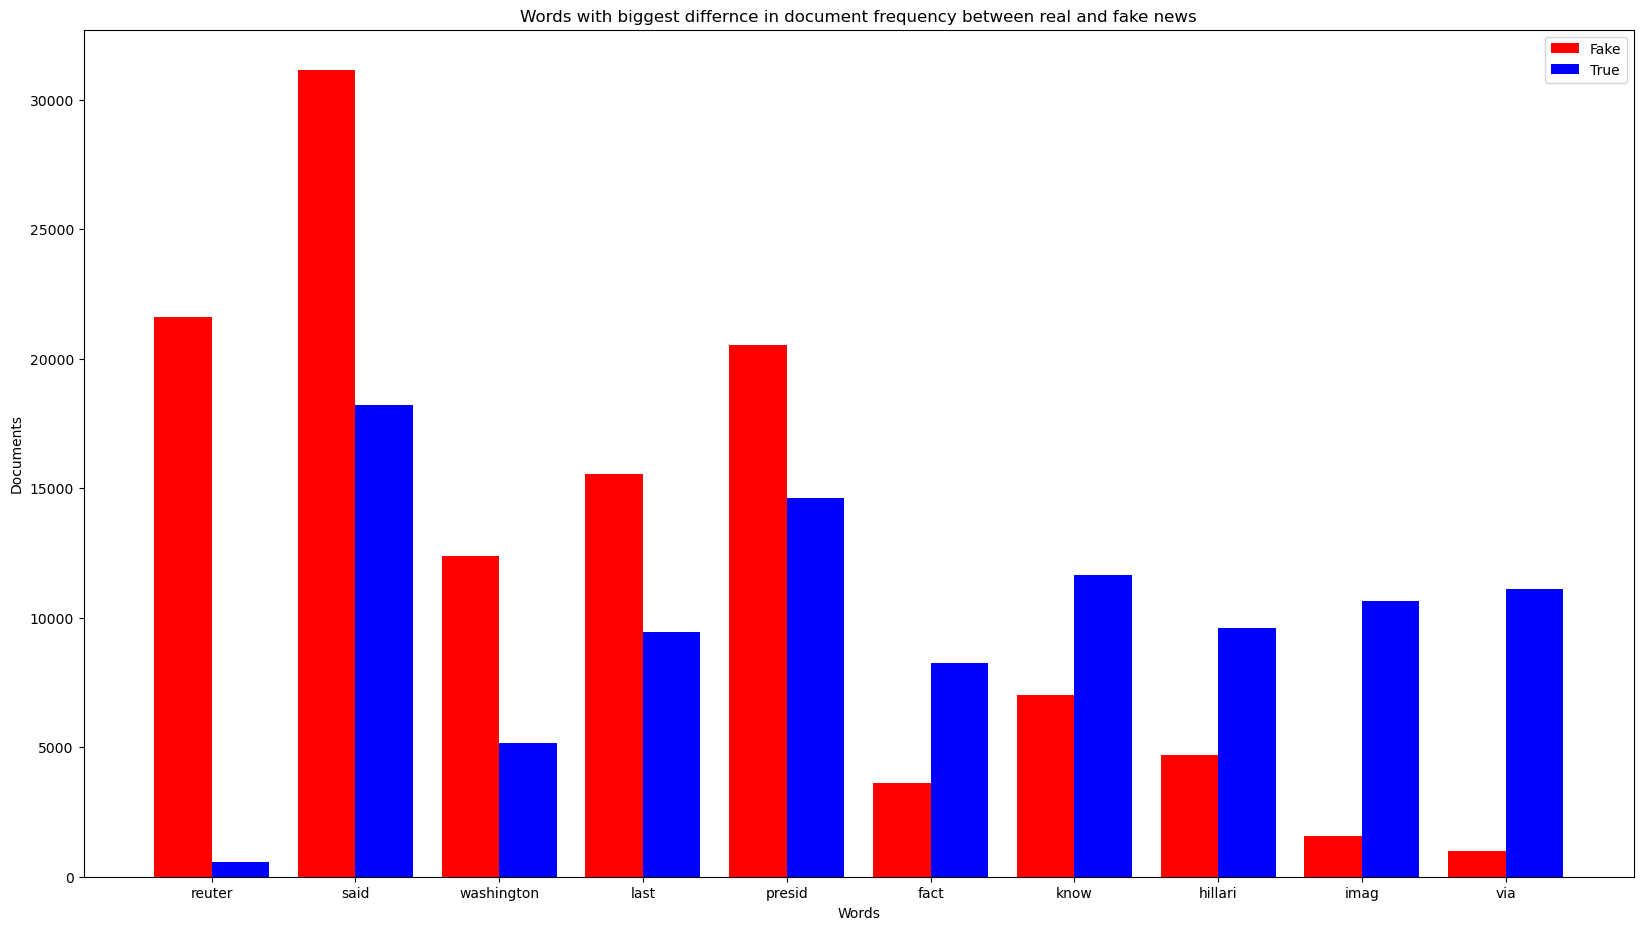

In [23]:
keys_for_docs = list(articles_with_word.keys())
polarizing_doc_words = {}
for word in keys_for_docs:
    if word not in fake_articles_with_word:
        a = 0
        b = true_articles_with_word[word]
    elif word not in true_articles_with_word:
        a = fake_articles_with_word[word]
        b = 0
    else:
        a = fake_articles_with_word[word]
        b = true_articles_with_word[word]
    polarizing_doc_words[word] = a-b
        
polarizing_word_docs = sorted(polarizing_doc_words.items(), key=lambda item: item[1], reverse=True)

top_polarizing_word_docs = polarizing_word_docs[:5] + polarizing_word_docs[-5:]

doc_polar_words = [word[0] for word in top_polarizing_word_docs]
doc_words_x, fake_doc_words, true_doc_words = generate_plot_data(doc_polar_words, fake_articles_with_word, true_articles_with_word)
X_axis = np.arange(len(doc_words_x))
plt.figure(figsize=(20, 11)) 
plt.bar(X_axis - 0.2, fake_doc_words, 0.4, label = 'Fake', color="red")
plt.bar(X_axis + 0.2, true_doc_words, 0.4, label = 'True', color="blue")


plt.xticks(X_axis, doc_words_x)
plt.xlabel("Words")
plt.ylabel("Documents")
plt.title("Words with biggest differnce in document frequency between real and fake news")
plt.legend()
plt.show()

## Splitting the dataset into training and test data

As we are now going to apply some specific preprocessing steps for our model, we need to split the dataset to prevent the test data being influenced by the training data and thereby not corrupt the evaluation, regarding the test data as previously unseen data.

We'll use 80% training data and 20% as test data

In [217]:
news_train = news.sample(frac=0.8, random_state=16)
news_test = news.drop(news_train.index)


news_train = news_train.sort_index()
news_train = news_train.reset_index()

news_test = news_test.sort_index()
news_test = news_test.reset_index()

Quickly checking the distribution of fn and n for bith datasets

In [244]:
n_fake_news_train = int(news_train["label"].value_counts()[0])
n_true_news_train = int(news_train["label"].value_counts()[1])

n_fake_news_train, n_true_news_train

(28008, 29699)

Our training set contains 28008 fake news articles and 29699 true news.

In [245]:
n_fake_news_test = int(news_test["label"].value_counts()[0])
n_true_news_test = int(news_test["label"].value_counts()[1])

n_fake_news_test, n_true_news_test

(7020, 7407)

Our test set has 7020 fake news and 7407 true news in it.

## CREATING A BASELINE MODELL

We'll use TF-IDF as a baseline

In [218]:
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_df=0.75) 

tfidf_train = tfidf_vectorizer.fit_transform(news_train["text"]) 

tfidf_test = tfidf_vectorizer.transform(news_test["text"]) 

y_train = news_train["label"]

y_test = news_test["label"]

We'll train the model to identify fn or tn based on a Naive Bayes Classifier. Thgis is altogether a very simple, very straightforward approach.

In [219]:
clf = MultinomialNB() 
clf.fit(tfidf_train, y_train)
tf_idf_predict = clf.predict(tfidf_test)
tf_idf_score = accuracy_score(y_test, tf_idf_predict)
print("accuracy:   %0.3f" % tf_idf_score)

accuracy:   0.867


We find quite a huge fn detection accuracy for such a simple and fast model - 87%

Now lets check, how well the model performs the recomendation task. For this we will use the Mean Average Precission at k - with k being 5, as the number of articles we want recommended. We assume the test dataset to be a complete collection of the news of the day, from which we want to recommend further relevant articles. 

In [252]:
tf_idf_test_vectorizer = TfidfVectorizer(stop_words='english', max_df=0.75) 
tfidf_eval_vec = tf_idf_test_vectorizer.fit_transform((news_test["text"]))

tf_idf_queries = news_test
all_predict_list = []
all_true_list = []
for i in range(len(tf_idf_queries)):
    quer_ind = tf_idf_queries.index[i]
    true_list = []
    predict_list = []
    cosine_sim = cosine_similarity(tfidf_eval_vec, tfidf_eval_vec[quer_ind])
    test_cosine_sim = cosine_similarity(tfidf_test, tfidf_test[quer_ind])
    sim_list = []
    test_sim_list =[]
    for arr in cosine_sim:
        for sim in arr:
            sim_list.append(sim)
    for arr in test_cosine_sim:
        for sim in arr:
            test_sim_list.append(sim)
    cosins = sorted(cosine_sim, key=lambda x: x[0], reverse=True)
    test_cosins = sorted(test_cosine_sim, key=lambda x: x[0], reverse=True)
    counter = 1
    while len(true_list)<5:
        cos_val = cosins[counter][0]
        sim_ind = sim_list.index(cos_val)
        if news_test.iloc[sim_ind]["label"] == 1:
            true_list.append(sim_ind)
        counter += 1
    all_true_list.append(true_list)
    counter = 1
    while len(predict_list)<5:
        test_cos_val = test_cosins[counter][0]
        test_sim_ind = test_sim_list.index(test_cos_val)
        if clf.predict(tfidf_test[test_sim_ind])[0] == 1:
            predict_list.append(test_sim_ind)
        counter += 1
    all_predict_list.append(predict_list)


Calculating the mean precission at k (Code taken from ml_metrics - the package would not install)

In [31]:
def apk(actual, predicted, k=5):
    if not actual:
        return 0.0

    if len(predicted)>k:
        predicted = predicted[:k]

    score = 0.0
    num_hits = 0.0
    for i,p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i+1.0)

    return score / min(len(actual), k)

def mapk(actual, predicted, k=5):
    return np.mean([apk(a,p,k) for a,p in zip(actual, predicted)])

In [255]:
mapk(all_true_list,all_predict_list)

0.5078226011413784

We get a MAP@k score of 0.51, meaning that on average half of the correct articles are returned

## Class relevant TF-IDF

To see which words are typically used in one kind of news, we calculated a subversion of the IDF for each term but based only on the appearance in the opposite class. So meaning that for a term that e.g. appeared in a true news article we considered only all fake news articles plus the one tn article we took as a base (So we imagined it being part of the fn corpus and checked, whether the term distinguishes it). We further checked for the same term what ist respective IDF score would be for a corpus of its original news type. If the difference between those two was 0.5 or more (in favor of the opposite corpus), we considered it to be a somewhat good indicator for its specific news type. Note, that we only included terms that appear in more than 10 documents in the respective news category. 

In [259]:
def idf_maker(class_dict_interested, class_dict_evaluate, n_interested, n_evaluate):
    idf_dict = {}
    for key, value in class_dict_interested.items():
        if value < 10:
            continue
        idf_own = np.log(n_interested/value)
        if key in class_dict_evaluate:
            idf = np.log((n_evaluate+1)/(class_dict_evaluate[key]+1))
        else:
            idf = np.log(n_evaluate/1)
        if idf - idf_own >= 0.5:
            idf_dict[key] = idf
    return idf_dict


In [260]:
n_fake_news_train = int(news_train["label"].value_counts()[0])
n_true_news_train = int(news_train["label"].value_counts()[1])

articles_with_word_train, fake_articles_with_word_train, true_articles_with_word_train = calculate_word_documents(news_train["text_clean"], news_train["label"])

idf_for_tn_words = idf_maker(true_articles_with_word_train, fake_articles_with_word_train, n_true_news_train, n_fake_news_train)
idf_for_fn_words = idf_maker(fake_articles_with_word_train, true_articles_with_word_train, n_fake_news_train, n_true_news_train)
idf_all = {**idf_for_fn_words, **idf_for_tn_words}

In [261]:
len(idf_for_fn_words), len(idf_for_tn_words), len(idf_all)

(7838, 7671, 15509)

Altogether 15509 terms have been identified to be overrepresented in one kind of news. 7838 specifically for fake news, 7671 specifically for true news.

Now having identified terms that indicate to some degree that a news article might be part of a specific news - based on the training data.

In [264]:
idf_for_fn_words["said"], idf_all["said"]

(0.7075944763068441, 0.7075944763068441)

Based on that we defined a function that factors in the term frequency for selecting whether or not an item is to be considered relevant, if its IDF is lower (tfidf - with the above stated particular calculation of idf). We did so, as the pure idf could not account for words such as said, that might appear in both categories (as seen above - hence the "low" IDF of 0.7 in the fn dict - it is btw not contained in the tn dict, so the discrimination works), but are used much more frequently in one category. In that way, they are factored in, if they are used multiple times in a document, but left out, if they are not used enough times, and thereby resemble the pattern of the opposite category. For this purpose it seemed adequate to only use a low threshhold for tfidf. 

In [265]:
def tf_idf_checker(term_list, idf_dict):
    idf_list = []
    idf_string = ""
    for term in term_list:
        if term in idf_dict:
            idf_list.append(term)
    for term in idf_list:
        if idf_dict[term]*idf_list.count(term) >= 2:
            idf_string = idf_string + term + " "
    return idf_string

In [266]:
news_train['idf_words'] = news_train.apply(lambda row: tf_idf_checker(row['text_clean'], idf_all), axis=1)


In [267]:
news_train.head(10)

,index,Unnamed: 0,title,text,label,text_clean,idf_words
0,0,0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1,"[comment, expect, barack, obama, member, fyf91...",expect barack blacklivesmatt lynch cop tuesday...
1,1,1,,Did they post their votes for Hillary already?,1,"[post, vote, hillari, alreadi]",hillari
2,2,2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1,"[demonstr, gather, last, night, exercis, const...",gather rais loretta lynch aka skirt
3,3,3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0,"[dozen, polit, activ, pastor, came, privat, di...",dozen friday louisiana gov bobbi jindal travel...
4,4,4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1,"[rs28, sarmat, missil, dub, satan, 2, replac, ...",rs28 sarmat missil satan replac ss18 43 mile r...
5,5,5,About Time! Christian Group Sues Amazon and SP...,All we can say on this one is it s about time ...,1,"[say, one, time, someon, su, southern, poverti...",southern tuesday ministri southern splc splc h...
6,7,7,HOUSE INTEL CHAIR On Trump-Russia Fake Story: ...,,1,[],
7,8,8,Sports Bar Owner Bans NFL Games…Will Show Only...,"The owner of the Ringling Bar, located south o...",1,"[owner, ringl, bar, locat, south, white, sulph...",bar south critic nfl bar tuesday read bar nfl ...
8,9,9,Latest Pipeline Leak Underscores Dangers Of Da...,"FILE – In this Sept. 15, 2005 file photo, the ...",1,"[file, sept, 15, 2005, file, photo, marker, we...",sept 2005 photo welcom commut okla ap undersco...
9,10,10,GOP Senator Just Smacked Down The Most Puncha...,The most punchable Alt-Right Nazi on the inter...,1,"[punchabl, altright, nazi, internet, got, thor...",altright nazi sass epic tweetstorm richard spe...


## Topic modelling

We want to do topic analysis to automatically group articles that talk about the same issue together, assuming that the topic makes them similar.

As a side note, in an initial conception, we wanted to differentiate between fn an tn within the topics based on sentiment scores, but had to cut that part out due to time and computational constraints.

As a initial step, we want to find topics corresponding to the news articles, and assign one to each article. We use Bertopic as it is, though new, yet a well established model and relatively easy to use. 

In [84]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "true"

In [86]:
topic_model = BERTopic(embedding_model = "multi-qa-mpnet-base-dot-v1")

docs = news_train["text"].to_list()

missing = ' '
for i in range(len(docs)):
    if docs[i] == missing:
        docs[i] = news_train["title"][i]

topics, probs = topic_model.fit_transform(docs)

Downloading: 100%|██████████| 190/190 [00:00<00:00, 150kB/s]
Downloading: 100%|██████████| 8.65k/8.65k [00:00<00:00, 5.74MB/s]
Downloading: 100%|██████████| 116/116 [00:00<00:00, 139kB/s]
Downloading: 100%|██████████| 25.5k/25.5k [00:00<00:00, 6.60MB/s]
Downloading: 100%|██████████| 438M/438M [03:00<00:00, 2.43MB/s] 
Downloading: 100%|██████████| 53.0/53.0 [00:00<00:00, 58.5kB/s]
Downloading: 100%|██████████| 239/239 [00:00<00:00, 259kB/s]
Downloading: 100%|██████████| 466k/466k [00:03<00:00, 149kB/s]  
Downloading: 100%|██████████| 363/363 [00:00<00:00, 122kB/s]
Downloading: 100%|██████████| 13.9k/13.9k [00:00<00:00, 108kB/s] 
Downloading: 100%|██████████| 232k/232k [00:00<00:00, 400kB/s]  
Downloading: 100%|██████████| 229/229 [00:00<00:00, 55.2kB/s]


In [87]:
topic_model.get_topic_info()

,Topic,Count,Name
0,-1,18434,-1_and_is_of_the
1,0,860,0_obamacare_insurance_health_healthcare
2,1,645,1_political_elites_america_establishment
3,2,610,2_voter_voting_fraud_voters
4,3,413,3_ban_order_travel_court
...,...,...,...
906,905,10,905_helmets_pottinger_propaganda_bell
907,906,10,906_forum_saker_flynn_technique
908,907,10,907_gore_climate_inconvenient_sequel
909,908,10,908_eu_european_nato_defense


Based on our training data we are left with 911 topics. Topic -1 is the largest, containing 18343 documents, yet this is the garbage topic. In which everything is put, that does not fit another topic. 

Adding this to our dataframe

In [88]:
news_train["topic"] = topics

And saving the model

In [122]:
topic_model.save("topics")

As well as the df

In [336]:
news_train.to_csv("newest_train_data.csv", index=False)

Resume where left of

In [292]:
news_train = pd.read_csv("newest_train_data.csv", index_col=0)

In [335]:
news_train.head(10)

,Unnamed: 0,title,text,label,text_clean,idf_words,topic
index,,,,,,,
0,0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1,"['comment', 'expect', 'barack', 'obama', 'memb...",expect barack blacklivesmatt lynch cop tuesday...,-1
1,1,NaN,Did they post their votes for Hillary already?,1,"['post', 'vote', 'hillari', 'alreadi']",hillari,-1
2,2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1,"['demonstr', 'gather', 'last', 'night', 'exerc...",gather rais loretta lynch aka skirt,-1
3,3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0,"['dozen', 'polit', 'activ', 'pastor', 'came', ...",dozen friday louisiana gov bobbi jindal travel...,138
4,4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1,"['rs28', 'sarmat', 'missil', 'dub', 'satan', '...",rs28 sarmat missil satan replac ss18 43 mile r...,892
5,5,About Time! Christian Group Sues Amazon and SP...,All we can say on this one is it s about time ...,1,"['say', 'one', 'time', 'someon', 'su', 'southe...",southern tuesday ministri southern splc splc h...,-1
7,7,HOUSE INTEL CHAIR On Trump-Russia Fake Story: ...,,1,[],NaN,-1
8,8,Sports Bar Owner Bans NFL Games…Will Show Only...,"The owner of the Ringling Bar, located south o...",1,"['owner', 'ringl', 'bar', 'locat', 'south', 'w...",bar south critic nfl bar tuesday read bar nfl ...,12
9,9,Latest Pipeline Leak Underscores Dangers Of Da...,"FILE – In this Sept. 15, 2005 file photo, the ...",1,"['file', 'sept', '15', '2005', 'file', 'photo'...",sept 2005 photo welcom commut okla ap undersco...,-1


Basically we now have all the information we need for our model. Lets have some looks at what is happening in the data, to then decide, what to include.

To facilitate this exploration, we split the training data (only for exploratory purposes) into dataframes for fake and for true news.

In [295]:
fake_mask = news_train["label"] == 0
fake_news_topics = set(news_train.loc[fake_mask, "topic"].tolist())
print(len(fake_news_topics))
fake_news_df = pd.DataFrame(news_train.loc[fake_mask, ["topic"]])

true_mask = news_train["label"] == 1
true_news_topics = set(news_train.loc[true_mask, "topic"].tolist())
print(len(true_news_topics))
true_news_df = pd.DataFrame(news_train.loc[true_mask, ["topic"]])

795
820


And how are our topics distributed between true and fake news?

First we check topics that are exclusive to one category.

In [296]:
only_fake_topics = fake_news_topics.difference(true_news_topics)
only_true_topics = true_news_topics.difference(fake_news_topics)
len(only_fake_topics), len(only_true_topics)

(91, 116)

We see that 91 topics are unique to fake news, while 116 topics only appear in true news.

In [297]:
def count_dict(some_df, column_name, value_list, label="all"):
    dic = {}
    for value in value_list:
        if value in some_df[column_name].values:
            count = some_df[column_name].value_counts()[value]
            dic[value] = count
        else:
            continue
    
    if label != "all":
        print(f"Altogether {sum(dic.values())} documents have a topic unique to {label} news.")
        print(f"That is {100*(sum(dic.values())/len(some_df))} percent of the documents within {label} news")
        print(f"They are disatributed as follows: {dic}")
    return dic


In [298]:
only_fake_topic_freq = count_dict(fake_news_df, "topic", list(only_fake_topics), "fake")
print()
only_true_topic_freq = count_dict(true_news_df, "topic", list(only_true_topics), "true")

Altogether 2173 documents have a topic unique to fake news.
That is 7.758497572122251 percent of the documents within fake news
They are disatributed as follows: {513: 22, 514: 22, 515: 22, 517: 22, 521: 21, 547: 20, 550: 20, 571: 20, 595: 19, 600: 19, 604: 19, 612: 18, 618: 18, 619: 18, 622: 18, 111: 76, 636: 17, 638: 17, 654: 17, 153: 62, 672: 16, 679: 16, 683: 16, 685: 16, 694: 15, 695: 15, 696: 15, 699: 15, 701: 15, 703: 15, 705: 15, 194: 54, 196: 54, 197: 53, 718: 15, 734: 14, 228: 47, 746: 14, 752: 14, 766: 13, 767: 13, 258: 43, 264: 42, 783: 13, 787: 13, 276: 40, 799: 13, 290: 39, 291: 39, 292: 38, 298: 38, 301: 38, 305: 37, 310: 37, 822: 12, 824: 12, 826: 12, 828: 12, 829: 12, 320: 36, 837: 12, 840: 12, 330: 36, 844: 12, 845: 12, 847: 12, 853: 11, 342: 34, 856: 11, 347: 34, 875: 11, 880: 11, 370: 32, 379: 31, 891: 11, 383: 31, 902: 10, 393: 30, 399: 30, 400: 29, 402: 29, 407: 29, 419: 28, 425: 27, 427: 27, 438: 27, 463: 25, 464: 25, 472: 24, 482: 24, 497: 23}

Altogether 2510 d

Now lets find out, how all topics are distributed over all documents, as well as within each category.

We define divisive topics, that are shifted more towards one category (80% of the topic-documents fall in it) and shared topics, which are covered by both news categories.

In [299]:
topics_list = news_train["topic"].unique().tolist()
all_topics = count_dict(news_train, "topic", topics_list)
all_fake_topics = count_dict(fake_news_df, "topic", topics_list)
all_true_topics = count_dict(true_news_df, "topic", topics_list)
divisive_topics = []
for topic in topics_list:
    if topic in only_true_topics:
        divisive_topics.append(topic)
    elif all_fake_topics[topic]/all_topics[topic] > 0.8:
        divisive_topics.append(topic)
    elif all_true_topics[topic]/all_topics[topic] > 0.8:
        divisive_topics.append(topic)

shared_topics = list(np.setdiff1d(topics_list, divisive_topics))

In [300]:
len(divisive_topics), len(topics_list), len(shared_topics)

(535, 911, 376)

We see that from all 911 topics 535 can be seen as divisive, while 376 are shared between both news categories.

Lets check, how many documents have a divisive and how many a shared topic. We excluded the garbage topic -1 - that holds a huge fraction of the documents.

In [301]:
shared_top_dict = dict(sorted(count_dict(news_train, "topic", shared_topics).items(), key=lambda x: x[1], reverse=True))
if -1 in shared_top_dict:
    del shared_top_dict[-1]
print(f"In total {sum(shared_top_dict.values())} documents out of {len(news_train)} cover a topic that occurs more balanced in both fake and real news")

In total 19181 documents out of 57707 cover a topic that occurs more balanced in both fake and real news


In [302]:
divisive_top_dict = dict(sorted(count_dict(news_train, "topic", divisive_topics).items(), key=lambda x: x[1], reverse=True))
if -1 in divisive_top_dict:
    del divisive_top_dict[-1]
print(f" {sum(divisive_top_dict.values())} documents out of {len(news_train)} cover a topic that is much more frequently covered by one type of news")

 20092 documents out of 57707 cover a topic that is much more frequently covered by one type of news


In [325]:
def topic_info_tn(number):
    word_list = [term[0] for term in topic_model.get_topic(number)] 
    print(f"Topic {number} appears {all_true_topics[number]} times in true news")
    print(f"It encompasses the following terms: {word_list}")

Lets plot the divisive topics separately for tn and fn.

The exclusively fake news topics look as follows

In [309]:
topic_model.visualize_topics(list(only_fake_topics))

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In the bottom left quadrant there seem to be more topics related to international politics.

While for exclusively true news it looks like this:

In [310]:
topic_model.visualize_topics(list(only_true_topics))

The true news form a big cluster around american politics centred on Donald Trump and Hillary Clinton to the left. Exploring that qualitatively increases the initial notion that the categories for tn and fn might have been switched in the dataset. And some topics are unexplainable for us. Like topic 45.

In [326]:
topic_info_tn(45)

Topic 45 appears 123 times in true news
It encompasses the following terms: ['что', 'на', 'не', 'это', 'по', 'как', 'то', 'мы', 'для', 'но']


Finally, lets also apply all the processing steps done on the training data to the test data. With the difference that the underlying calculations are  based on the training data. We therefore treat it as unseen news, not knowing the label.

In [115]:
news_test = news_test.sort_index()
news_test = news_test.reset_index()


news_test['idf_words'] = news_test.apply(lambda row: tf_idf_checker(row['text_clean'], idf_all), axis=1)

test_docs = news_test["text"].to_list()

missing = ' '
for i in range(len(test_docs)):
    if test_docs[i] == missing:
        test_docs[i] = news_test["title"][i]

test_topics, test_probs = topic_model.transform(test_docs)

news_test["topic"] = test_topics

/Users/luka/opt/miniconda3/lib/python3.9/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


Making a restart point

In [334]:
#news_test.to_csv("newest_test_data.csv", index=False)

In [332]:
#news_test = pd.read_csv("newest_test_data.csv",  index_col=0)

In [333]:
news_test.head(10)

,index,Unnamed: 0,title,text,label,text_clean,idf_words,text_sentiment_score,topic
level_0,,,,,,,,,
0,6,6,DR BEN CARSON TARGETED BY THE IRS: “I never ha...,DR. BEN CARSON TELLS THE STORY OF WHAT HAPPENE...,1,"['dr', 'ben', 'carson', 'tell', 'stori', 'happ...",NaN,0.0000,175
1,15,15,Billionaire Odebrecht in Brazil scandal releas...,RIO DE JANEIRO/SAO PAULO (Reuters) - Billionai...,0,"['rio', 'de', 'janeirosao', 'paulo', 'reuter',...",rio de paulo reuter marcelo odebrecht highestp...,-0.9638,-1
2,16,16,BRITISH WOMAN LOSES VIRGINITY To Asylum Seekin...,Europe is likely not going to be a top destina...,1,"['europ', 'like', 'go', 'top', 'destin', 'fami...",top destin idioci invas foreign asylum seeker ...,-0.9991,-1
3,23,23,UNHOLY ALLIANCE: Hillary Clinton’s Saudi Spons...,21st Century Wire says Amid the tossing and t...,1,"['21st', 'centuri', 'wire', 'say', 'amid', 'to...",21st centuri wire amid focus actual hillari cl...,-0.9988,-1
4,27,27,Islamic State driven out of last stronghold in...,BAGHDAD (Reuters) - Iraqi forces announced on ...,0,"['baghdad', 'reuter', 'iraqi', 'forc', 'announ...",baghdad reuter iraqi thursday captur islam las...,-0.9612,-1
5,33,33,"Schaeuble to head German parliament, unblockin...",BERLIN (Reuters) - Germany took a first decisi...,0,"['berlin', 'reuter', 'germani', 'took', 'first...",berlin reuter germani decis step wednesday fin...,0.9982,672
6,45,45,Sekulow: Expect ‘Whining Testimony’ from Comey...,"Jay Sekulow, Chief Counsel of the American Cen...",0,"['jay', 'sekulow', 'chief', 'counsel', 'americ...",chief daili siriusxm raheem kassam wednesday f...,0.9598,78
7,51,51,Fear of Iranian general left Iraqi Kurdish oil...,BAGHDAD/LONDON (Reuters) - When the Iraqi army...,0,"['baghdadlondon', 'reuter', 'iraqi', 'armi', '...",reuter iraqi armi iranianback shi ite militia ...,-0.9857,18
8,53,53,U.S. patent review board becomes conservative ...,"NEW YORK(Reuters) - In August, a dozen invento...",0,"['new', 'yorkreut', 'august', 'dozen', 'invent...",dozen gather pit headquart patent alight paten...,0.9748,-1


## TRAINING & TESTING A BERT MODEL




In this part we will train models which predict if an article is true or fake news, based on a Bert layer and an additional layer which includes the topics.

We will try this with all data and additionally with reduced training and testing data where articles with the category '-1' are removed from the dataframe (The "garbage-category" -1 indicates that an article could not be categorized).

In [2]:
def remove_garbage_category(dataframe):
   filtered_data = dataframe.loc[dataframe['topic'] != -1] 
   filtered_data = filtered_data.loc[filtered_data['topic'] != '-1'] 
   return filtered_data

In [3]:
train_data = pd.read_csv('newest_train_data.csv', engine='python', encoding='utf-8', on_bad_lines='skip').fillna('')
print(f'train data before cleanup {len(train_data)}')
train_data_cleaned = remove_garbage_category(train_data)
print(f'train data after cleanup {len(train_data_cleaned)}')

test_data = pd.read_csv('newest_test_data.csv', engine='python', encoding='utf-8', on_bad_lines='skip').fillna('')
print(f'test data before cleanup {len(test_data)}')
test_data_cleaned = remove_garbage_category(test_data)
print(f'test data after cleanup {len(test_data_cleaned)}')

train data before cleanup 57733
train data after cleanup 39299
test data before cleanup 14427
test data after cleanup 8674


## Tokenize data

For the tokenization we use the existing BERT model 'bert-base-uncased', a transformer model which is pretrained on a large corpus of English data, and only with texts.
It is pretrained with MLM (masked language modeling) & NSP (next sentence prediction).
This means that the model learns a representation of the English language, in which we want to integrate topics in order to detect true & fake news.

In [4]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

Tokenizing the data of our datafame that includes the topics, labels and the class relevant tfidf presentation of the text.
The outputs here are input_ids and attention_masks which the BertTokenizer creates and the corresponding label and topic tensors.

In [5]:
def tokenize_data(data):
    labels = []
    topics = []
    input_ids = []
    attention_masks = []
    for index, line in data.iterrows():
        try:
            labels.append(int(line.label))
            topics.append(int(line.topic))
        except:
            continue
        encoded_dict = tokenizer.encode_plus(
                            line.idf_words,
                            add_special_tokens = True, 
                            truncation = 'longest_first', 
                            max_length = 100, 
                            pad_to_max_length = True, 
                            return_attention_mask = True, 
                            return_tensors = 'pt') 
        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])
    
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    try:
        labels = torch.tensor(labels)
    except:
        print(labels)

    topics = torch.tensor(topics)
    return input_ids, attention_masks, labels, topics

As we have 2 different datasets (cleaned and uncleaned) where the only difference is that we removed the articles which are specified in the "garbage-category" we tokenize both of those datasets in their corresponding train & test sets.

In [9]:
test_input_ids, test_attention_masks, test_labels, test_topics = tokenize_data(test_data)
train_input_ids, train_attention_masks, train_labels, train_topics = tokenize_data(train_data) 

In [10]:
test_input_ids_cleaned, test_attention_masks_cleaned, test_labels_cleaned, test_topics_cleaned = tokenize_data(test_data_cleaned)
train_input_ids_cleaned, train_attention_masks_cleaned, train_labels_cleaned, train_topics_cleaned = tokenize_data(train_data_cleaned) 

In [21]:
# Declare GPU as device to run on
device = torch.device("cuda")

In [22]:
# Move tensors to GPU
test_input_ids = test_input_ids.to(device)
test_attention_masks = test_attention_masks.to(device)
test_labels = test_labels.to(device)
test_topics = test_topics.to(device)

train_input_ids = train_input_ids.to(device)
train_attention_masks = train_attention_masks.to(device)
train_labels = train_labels.to(device)
train_topics = train_topics.to(device)

In [23]:
train_dataset = TensorDataset(train_input_ids, train_attention_masks, train_labels, train_topics)
val_dataset = TensorDataset(test_input_ids, test_attention_masks, test_labels, test_topics)

In [24]:
train_dataset_cleaned = TensorDataset(train_input_ids_cleaned, train_attention_masks_cleaned, train_labels_cleaned, train_topics_cleaned)
val_dataset_cleaned = TensorDataset(test_input_ids_cleaned, test_attention_masks_cleaned, test_labels_cleaned, test_topics_cleaned)

## Creating Dataloaders

Dataloaders including the garbage category

In [25]:
batch_size = 64

train_dataloader = DataLoader(
                dataset=train_dataset,
                batch_size=batch_size,
                shuffle=True,
                drop_last=True)

val_dataloader = DataLoader(
                dataset=val_dataset,
                batch_size=batch_size,
                shuffle=True,
                drop_last=True)



Dataloaders not including the garbage category

In [26]:
batch_size = 64

train_dataloader_cleaned = DataLoader(
                dataset=train_dataset_cleaned,
                batch_size=batch_size,
                shuffle=True,
                drop_last=True)

val_dataloader_cleaned = DataLoader(
                dataset=val_dataset_cleaned,
                batch_size=batch_size,
                shuffle=True,
                drop_last=True)

## BERTPlusModel

The model that we use for training and testing includes 3 different layers.
#### 1: BERT 
it includes the pretrained bert model which we use
#### 2: Dropout 
#### 3: Linear Layer
the linear layer includes the topics to the output of the Bert model


##### Loss function:
The loss function is BCEWithLogitsLoss because it acts similar to a sigmoid layer + BCELoss and therefore we can apply it to our labels in the sense of a binary classification problem (0, 1) or (TRUE, FAKE)



In [11]:
class BertPlusModel(torch.nn.Module):
    def __init__(self, bert_model):
        super(BertPlusModel, self).__init__()
        self.bert_model = bert_model
        self.linear = torch.nn.Linear(769, 1) 
        self.dropout = torch.nn.Dropout(p=0.2)

    def forward(self, input_ids, attention_mask, additional_input):
        _, pooled_output = self.bert_model(input_ids=input_ids, attention_mask=attention_mask).to_tuple()
        concatenated = torch.cat((pooled_output, additional_input.unsqueeze(dim=1)), dim=1)
        concatenated = self.dropout(concatenated)
        return self.linear(concatenated)


bert_model = transformers.BertModel.from_pretrained('bert-base-uncased')


model_uncleaned = BertPlusModel(bert_model)
model_cleaned = BertPlusModel(bert_model)
loss_fn = torch.nn.BCEWithLogitsLoss()
optimizer_uncleaned = torch.optim.Adam(model_uncleaned.parameters(), lr=0.00004)
optimizer_cleaned = torch.optim.Adam(model_cleaned.parameters(), lr=0.00004)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


## Training the model

In [ ]:
def train(data_loader, model, optimizer, filenametosave):
    model.train()  
    total_step = len(data_loader.dataset)
    for epoch in range(5):
        total_loss = 0
        for i, batch in enumerate(data_loader := tqdm(data_loader, total=len(data_loader))):
            input_ids, attention_masks, labels, topics = batch        
            output = model(input_ids, attention_masks, topics)
            labels = labels.type(torch.float).unsqueeze(1)
            loss = loss_fn(output, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        print('Epoch: {}, Loss: {:.4f}'.format(epoch+1, total_loss / total_step))
    torch.save(model.state_dict(), filenametosave+".pt")

## Testing the model

In [29]:
def test(data_loader, model):
    model.eval()

    total_loss = 0
    num_correct = 0
    num_samples = 0
        
    for epoch in range(5):
        for batch in val_dataloader:
                input_ids, attention_masks, labels, topics = batch
        
                with torch.no_grad():
                    output = model(input_ids, attention_masks, topics)
                    labels = labels.type(torch.float).unsqueeze(1)
                    loss = loss_fn(output,  labels)
                
                total_loss += loss.item() * input_ids.size(0)
                num_samples += input_ids.size(0)
                
                output = torch.round(torch.sigmoid(output))
                correct_entries = torch.eq(output, labels)
                num_correct += torch.sum(correct_entries)
            
        print(f'epoch: {epoch+1}, val_loss: {total_loss / num_samples:.4f}, val_acc: {num_correct / num_samples:.4f}')

Train & test the model with the garbage-category articles included

In [17]:
train(train_dataloader, model_uncleaned, optimizer_uncleaned, "uncleaned_model")
test(val_dataloader, model_uncleaned)

100%|█████████████████████████████████████████████████████████████████████████████████| 901/901 [07:12<00:00,  2.08it/s]


Epoch: 1, Loss: 0.0091


100%|█████████████████████████████████████████████████████████████████████████████████| 901/901 [07:08<00:00,  2.10it/s]


Epoch: 2, Loss: 0.0020


100%|█████████████████████████████████████████████████████████████████████████████████| 901/901 [07:07<00:00,  2.11it/s]


Epoch: 3, Loss: 0.0010


100%|█████████████████████████████████████████████████████████████████████████████████| 901/901 [06:51<00:00,  2.19it/s]


Epoch: 4, Loss: 0.0005


100%|█████████████████████████████████████████████████████████████████████████████████| 901/901 [06:56<00:00,  2.17it/s]


Epoch: 5, Loss: 0.0004
epoch: 1, val_loss: 0.1163, val_acc: 0.9708
epoch: 2, val_loss: 0.1166, val_acc: 0.9708
epoch: 3, val_loss: 0.1167, val_acc: 0.9708
epoch: 4, val_loss: 0.1167, val_acc: 0.9708
epoch: 5, val_loss: 0.1166, val_acc: 0.9708



The model with the garbage category included has an accuracy of 97% in fake news recognition. 
It seems that this approach is quite good at doing its job.

Train & test the model without the garbage-category articles

In [30]:
# Declare GPU as device to run on
device = torch.device("cuda")

In [31]:
model_cleaned = model_cleaned.to(device)

#Move tensors to GPU

test_input_ids_cleaned = test_input_ids_cleaned.to(device)
test_attention_masks_cleaned = test_attention_masks_cleaned.to(device)
test_labels_cleaned = test_labels_cleaned.to(device)
test_topics_cleaned = test_topics_cleaned.to(device)

train_input_ids_cleaned = train_input_ids_cleaned.to(device)
train_attention_masks_cleaned = train_attention_masks_cleaned.to(device)
train_labels_cleaned = train_labels_cleaned.to(device)
train_topics_cleaned = train_topics_cleaned.to(device)

In [32]:
train(train_dataloader_cleaned, model_cleaned, optimizer_cleaned, "cleaned_model")
test(val_dataloader_cleaned, model_cleaned)

100%|█████████████████████████████████████████████████████████████████████████████████| 613/613 [04:41<00:00,  2.18it/s]


Epoch: 1, Loss: 0.0064


100%|█████████████████████████████████████████████████████████████████████████████████| 613/613 [04:38<00:00,  2.20it/s]


Epoch: 2, Loss: 0.0014


100%|█████████████████████████████████████████████████████████████████████████████████| 613/613 [04:36<00:00,  2.22it/s]


Epoch: 3, Loss: 0.0008


100%|█████████████████████████████████████████████████████████████████████████████████| 613/613 [04:38<00:00,  2.20it/s]


Epoch: 4, Loss: 0.0005


100%|█████████████████████████████████████████████████████████████████████████████████| 613/613 [04:40<00:00,  2.18it/s]


Epoch: 5, Loss: 0.0003
epoch: 1, val_loss: 0.1396, val_acc: 0.9635
epoch: 2, val_loss: 0.1396, val_acc: 0.9635
epoch: 3, val_loss: 0.1393, val_acc: 0.9636
epoch: 4, val_loss: 0.1393, val_acc: 0.9636
epoch: 5, val_loss: 0.1393, val_acc: 0.9636


Interestingly the accuracy decreases without the garbage category, yet it still remains very high.

In [13]:
# Not part of the code, just to load topics form the first part

#topic_model = BERTopic.load("topics")

In [15]:
# Get the pretrained BERT model

bert_model = transformers.BertModel.from_pretrained('bert-base-uncased')

# Initialize the model with the pretrained BERT model

model_uncleaned = BertPlusModel(bert_model)

# Load model CPU

model_uncleaned.load_state_dict(torch.load('uncleaned_model.pt', map_location='cpu'))

# Set the model to evaluation mode

model_uncleaned.eval()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BertPlusModel(
  (bert_model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affin

In [16]:
# Get the pretrained BERT model
bert_model = transformers.BertModel.from_pretrained('bert-base-uncased')

# Initialize the model with the pretrained BERT model
model_cleaned = BertPlusModel(bert_model)

# Load model CPU
model_cleaned.load_state_dict(torch.load('cleaned_model.pt', map_location='cpu'))

# Set the model to evaluation mode
model_cleaned.eval()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BertPlusModel(
  (bert_model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affin

Finally we wanted to set up our recommendations and evaluate them against recommendations with the tn and fn labels known. We want to recommend five further articles to readers. They should be similar to one article they already read, meaning that they cover the same or a similar topic, but they should be true, so we try to predict their class. 

Therefore the article they read serves as the query.

For evaluation we use the Mean Average Precission at k. 

In [53]:
#train_data_cleaned.reset_index(drop=True, inplace=True)
test_data_cleaned.reset_index(drop=True, inplace=True)

We need some functions for that

In [18]:
def get_topic_id(article, dataset):
        return dataset["topic"][article]

In [297]:
def filter_artciles_with_same_topic(topic, query, dataset):
    filtered_articles = dataset.loc[dataset['topic'] == int(topic)]
    

    filtered_articles1 = dataset.loc[dataset['topic'] == str(topic)]
   
    filtered_articles = filtered_articles.loc[filtered_articles['text'] != " "]
    filtered_articles = filtered_articles.loc[filtered_articles['text'] != ""]
    filtered_articles1= filtered_articles1.loc[filtered_articles1['text'] != " "]
    texts = []
    texts = filtered_articles["text"].tolist()
    texts1 = filtered_articles1["text"].tolist()
    texts = texts + texts1
    vectorizer = TfidfVectorizer()
    if len(texts) > 0:
        vectors = vectorizer.fit_transform(texts)
        query_vector = vectorizer.transform([(dataset["text"][query])])
        similarities = cosine_similarity(query_vector, vectors)[0]
        filtered_articles['cosine_similarity'] = similarities
        filtered_articles = filtered_articles.sort_values(by='cosine_similarity', ascending=False)
        filtered_articles.drop(index=filtered_articles.index[0], axis=0, inplace=True)
    return filtered_articles

In [150]:
def filter_artciles_with_similar_topic(topic, query, dataset):
    filtered_articles = dataset.loc[dataset['topic'] == int(topic)]
    

    filtered_articles1 = dataset.loc[dataset['topic'] == str(topic)]
   
    filtered_articles = filtered_articles.loc[filtered_articles['text'] != " "]
    filtered_articles = filtered_articles.loc[filtered_articles['text'] != ""]
    filtered_articles1= filtered_articles1.loc[filtered_articles1['text'] != " "]
    texts = []
    texts = filtered_articles["text"].tolist()
    texts1 = filtered_articles1["text"].tolist()
    texts = texts + texts1
    
    vectorizer = TfidfVectorizer()
    if len(texts) > 0:
        vectors = vectorizer.fit_transform(texts)
        query_vector = vectorizer.transform([(dataset["text"][query])])
        similarities = cosine_similarity(query_vector, vectors)[0]
        filtered_articles['cosine_similarity'] = similarities
        filtered_articles = filtered_articles.sort_values(by='cosine_similarity', ascending=False)
    return filtered_articles

In [202]:
def filter_articles_based_on_predictions(articles, predictions, RECOMMENDATION_SIZE):
    result = []
    recommendations_found = 0
    for article_index, prediction in zip(articles['index'], predictions):
        if(prediction == 1):
            result.append(article_index)
            recommendations_found += 1
            if(recommendations_found >= RECOMMENDATION_SIZE):
                return result
    return result

In [21]:
def predict_label(query):
    if query.empty:
        output = torch.zeros([0,1])
    else:
        query_input_ids, query_attention_masks, query_labels, query_topics= tokenize_data(query)
        output = model_cleaned(query_input_ids, query_attention_masks, query_topics)
        query_labels = query_labels.type(torch.float).unsqueeze(1)
        output = torch.round(torch.sigmoid(output))  
    return output


The recommendation function takes an article as a query. It then checks all other articles covering the same topic, whether they are seen as true and recommends them, if they are. If this is not enough, it switches to the next similar topic and checks for the same. Within one topic documents are ranked based on tfidf and the most similar ones are recommended first.

At the same time the function calculates the same with the class labels known, so that both can be evaluated against each other.

In [346]:
def get_recommendations(dataset):

    RECOMMENDATION_SIZE = 5
    sim_matrix = cosine_similarity(topic_model.topic_embeddings_, topic_model.topic_embeddings_)
    recommendations = []
    should_recommend = []

    
    for i in range(len(dataset)):
        query = i
        print(query)
        topic_id = get_topic_id(query, dataset)
        articles_with_same_topic = filter_artciles_with_same_topic(topic_id, query, dataset)
        predictions = predict_label(articles_with_same_topic).squeeze(1)
        recommended_articles = filter_articles_based_on_predictions(articles_with_same_topic, predictions, RECOMMENDATION_SIZE)
        true_values = torch.tensor(articles_with_same_topic["label"].values)
        should_recommend_articles = filter_articles_based_on_predictions(articles_with_same_topic, true_values, RECOMMENDATION_SIZE)
        sim_counter = 0
        while len(recommended_articles) < 5:
            sim_counter += 1
            top_array = sim_matrix[topic_id]
            next_large = np.sort(top_array)
            next_value = next_large[len(next_large)-sim_counter]
            val_index = np.where(top_array == next_value)[0][0]-1
            articles_other_topic = filter_artciles_with_similar_topic(val_index, query, dataset)
            true_values_other = torch.tensor(articles_other_topic["label"].values)
            predictions_other = predict_label(articles_other_topic).squeeze(1)
            additional_articles = filter_articles_based_on_predictions(articles_other_topic, predictions_other, RECOMMENDATION_SIZE-(len(recommended_articles)))
            recommended_articles = recommended_articles + additional_articles
        recommendations.append(recommended_articles)
            
        sim_counter = 0
        while len(should_recommend_articles) < 5:
            sim_counter += 1
            top_array = sim_matrix[topic_id]
            next_large = np.sort(top_array)
            next_value = next_large[len(next_large)-sim_counter]
            val_index = np.where(top_array == next_value)[0][0]-1
            articles_other_topic = filter_artciles_with_similar_topic(val_index, query, dataset)
            true_values_other = torch.tensor(articles_other_topic["label"].values)
            additional_should_articles = filter_articles_based_on_predictions(articles_other_topic, true_values_other, RECOMMENDATION_SIZE-(len(should_recommend_articles)))
            should_recommend_articles = (should_recommend_articles + additional_should_articles)
        if len(should_recommend_articles) > 5:
            should_recommend_articles = should_recommend_articles[:5]
        should_recommend.append(should_recommend_articles)
    
    return should_recommend, recommendations

Due to several kernel crashes and freezing computers, we had to reduce the sample size for the evaluation to 1000. 

In [ ]:
RECOMMENDATION_SIZE = 5
sim_matrix = cosine_similarity(topic_model.topic_embeddings_, topic_model.topic_embeddings_)
recommendations = []
should_recommend = []


eval_data = test_data_cleaned.sample(n=1000, random_state=18).reset_index(drop=True)
should_recommend, recommendations = get_recommendations(eval_data)

Lastly we calculate the Mean Average Precission at k for the recommended articles against those that should ghave been recommended. The MAPK function itself was already defined for the baseline model. 

In [349]:
mapk(should_recommend,recommendations)

0.9270033333333334

The Mean Average Precission at k for our model against a calculation in which the labels are known is 0.94. 

Our baseline model (although calculated differently) had only around 0.5

Our model is therefore quite good at recommending true news articles to readers, based on the topics they are interested in.

The downsides to it are the large amount of topics in the "garbage category" given out by BERTopic.